# NYC Taxi and Limousine Commission Dataset Mining

# Table of contents
1. [Introduction](#introduction)
2. [Exploratory Data Analysis](#eda)
    1. [Airport Trips](#airport)
3. [Predictive Model for Tip](#predictive)
    1. [Feature Engineering](#featureengg)
    1. [Building and Evaluating the Model](#buildingmodel)

## Introduction <a name="introduction"></a>

In this project we analyze a subset of the NYC Taxi and Limousine Commission dataset (available [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)). Specifically, we consider Green Taxi data from September 2015. Green taxis do not operate in the Hail Exclusionary Zone in Manhattan, south of West 110th St and East 96th St.

The main goals for this analysis are to:
- Obtain the data
- Perform exploratory data analysis
- Build a predictive model for the tip amount

In [0]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Setting plotting parameters
plt.rcParams['figure.figsize'] = 18, 8
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 16

sns.set_style("whitegrid")

The dataset can be downloaded using the `pandas.read_csv` function.

In [0]:
url="https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
df = pd.read_csv(url)

The number of rows and columns of data can be determined using the `shape` method, giving the number of rows = 1494926, and the number of columns = 21.
The number of rows represent the number of samples in the dataset, and the number of columns represent the number of features.

In [4]:
df.shape

(1494926, 21)

In [5]:
# An overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494926 entries, 0 to 1494925
Data columns (total 21 columns):
VendorID                 1494926 non-null int64
lpep_pickup_datetime     1494926 non-null object
Lpep_dropoff_datetime    1494926 non-null object
Store_and_fwd_flag       1494926 non-null object
RateCodeID               1494926 non-null int64
Pickup_longitude         1494926 non-null float64
Pickup_latitude          1494926 non-null float64
Dropoff_longitude        1494926 non-null float64
Dropoff_latitude         1494926 non-null float64
Passenger_count          1494926 non-null int64
Trip_distance            1494926 non-null float64
Fare_amount              1494926 non-null float64
Extra                    1494926 non-null float64
MTA_tax                  1494926 non-null float64
Tip_amount               1494926 non-null float64
Tolls_amount             1494926 non-null float64
Ehail_fee                0 non-null float64
improvement_surcharge    1494926 non-null float64
To

Some of the important features in this dataset are as follows, with information from the data dictionary:

* lpep_pickup_datetime - The date and time the meter was engaged
* lpep_dropoff_datetime - The date and time the meter was disengaged
* pickup_longitude and pickup_latitude - Location where meter was engaged
* dropoff_longitude and dropoff_latitude - Location where meter was disengaged
* trip_distance - Elapsed trip distance in *miles* reported by the taximeter
* payment_type - Code signifying the mode of payment
* fare_amount - Time and distance fare calculated by the meter
* tip_amount - This field is automatically populated for credit card tips. *Cash tips are not included.*
* total_amount - The total amount charged, *which does not include cash tips*

This list is not exhaustive, and the dataset contains additional features such as surcharges, toll amounts etc.

## Exploratory Data Analysis <a name="eda"></a>

We now proceed to explore the features present in the dataframe.

Taking a look at the trip distance

In [6]:
# Check the distribution of the trip distance
df['Trip_distance'].describe()

count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64

Plot the histogram of the trip distance data in order to get an idea about the distribution

Text(0.5,0,'Trip Distance')

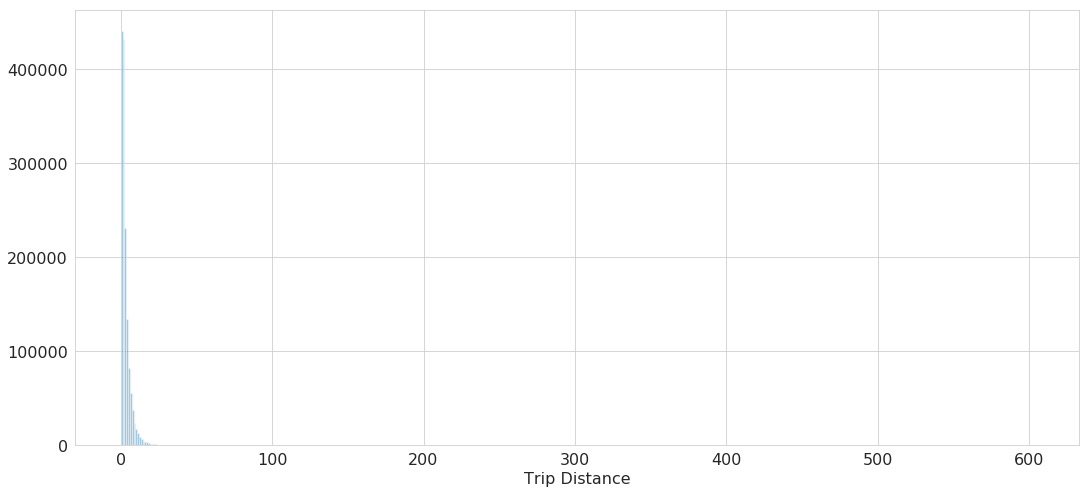

In [7]:
sns.distplot(df['Trip_distance'], kde=False, rug=False, bins=500);
plt.xlabel('Trip Distance')

An immediately noticeable characteristic of this histogram is that the majority of the data lies within a small range. For the trip distance data, the `99th percentile = 14.77`, which gives a good idea of this limited range. Plotting the data that lies in this range gives a clearer idea about the distribution of the data,

In [8]:
perc_99 = np.percentile(df['Trip_distance'], 99)
perc_99

14.77

Text(0.5,0,'Trip Distance')

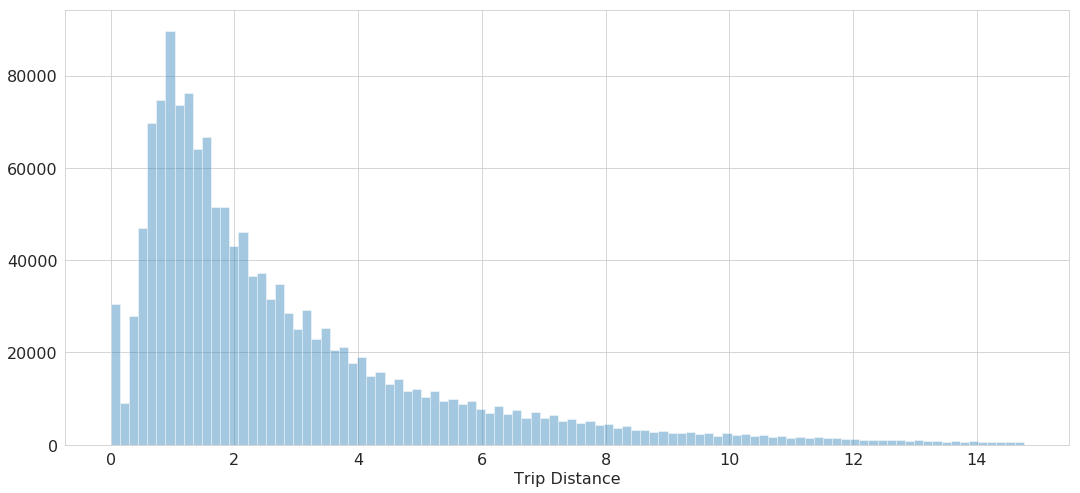

In [9]:
trip_distance = df[df['Trip_distance']<perc_99]['Trip_distance']
sns.distplot(trip_distance, kde=False, rug=False, bins=100);
plt.xlabel('Trip Distance')

At this scale, the histogram is clearly seen to be non-normal and right-skewed. Based on the discussion [here](http://www.itl.nist.gov/div898/handbook/eda/section3/histogr6.htm), we can draw a few inferences from this distribution. The reason for the right-skewedness of the histogram is the natural lower limit of measureable distance (i.e. 0). Right-skewedness is commonly observed in data that have a lower bound, as in this case. In such a histogram the mean and the median also differ from each other. We quantitatively summarize the data-

In [10]:
df['Trip_distance'].describe()

count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64

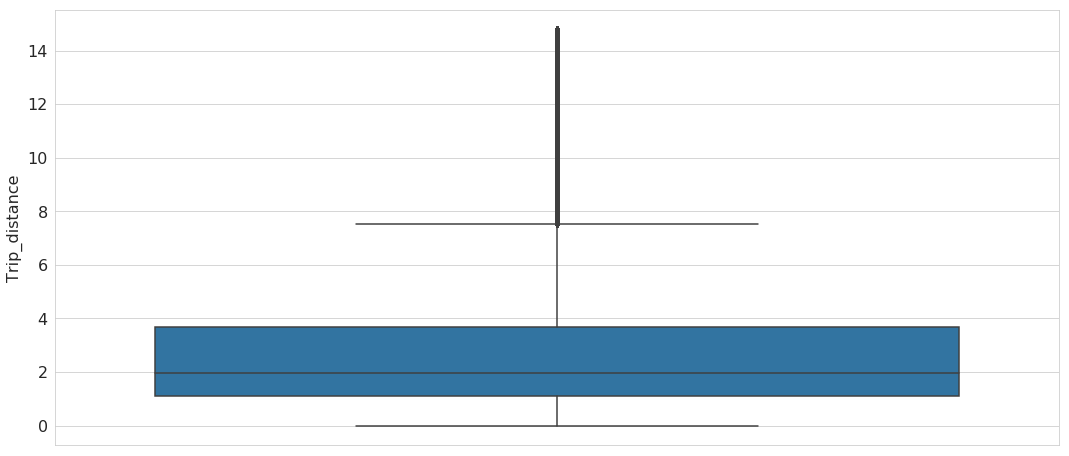

In [11]:
sns.boxplot(y=trip_distance)

The mean trip distance is `2.968 miles`, while the median or 50th percentile is `1.98 miles`. This is due to the skew of the histogram. We can try to identify the best fit distribution based on the observed right-skew characteristic. Some possible distributions that can be used to explain the samples are -

* Weibull family
* Gamma family
* Lognormal family

We try to fit the normalized trip distance histogram with these distributions. As pointed out [here](http://stackoverflow.com/questions/29208440/fit-a-distribution-to-a-histogram), the location parameters for the distributions are fixed at 0, since that is where the domain begins.

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


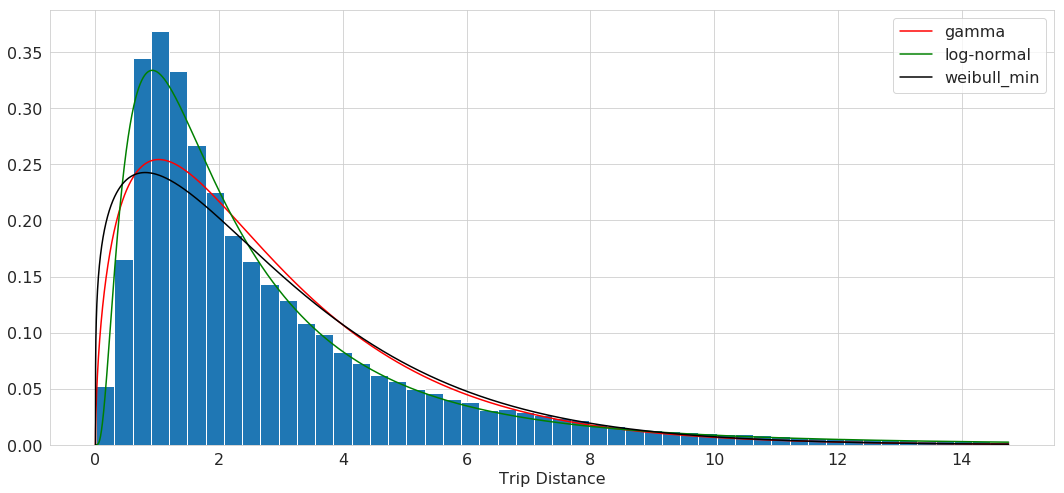

In [12]:
# Import the stats module from scipy
from scipy import stats

# The fitting functions require the data to be positive valued, especially for fitting the 
# log-normal distribution, so we take positive-valued trip distances, which are in the 99th 
# percentile

y = df[(df['Trip_distance']<perc_99) & (df['Trip_distance']>0)]['Trip_distance']
lnspc = np.linspace(0, max(y), len(y))

# Plot the normalized histogram
plt.hist(y, normed=True, bins=50)

# Fit the distributions
# Set floc=0, to fix the location parameters

# Gamma distribution
param_g = stats.gamma.fit(y, floc=0)
pdf_fitted = stats.gamma.pdf(lnspc, *param_g)
plt.plot(lnspc, pdf_fitted, color='r', label='gamma')

# Log-normal distribution
param_ln = stats.lognorm.fit(y, floc=0)
pdf_fitted_ln = stats.lognorm.pdf(lnspc, *param_ln)
plt.plot(lnspc, pdf_fitted_ln, color='g', label='log-normal')

# Weibull distribution
param_wb = stats.weibull_min.fit(y, floc=0)
pdf_fitted_wb = stats.weibull_min.pdf(lnspc, *param_wb)
plt.plot(lnspc, pdf_fitted_wb, color='k', label='weibull_min')

plt.xlabel('Trip Distance')
plt.legend()
plt.show()

The log-normal distribution estimates the trip distance samples well. The variable $X$ is log-normally distributed if $Y=ln(X)$ is normally distributed. To verify this, 

Text(0.5,0,'log-Trip Distance')

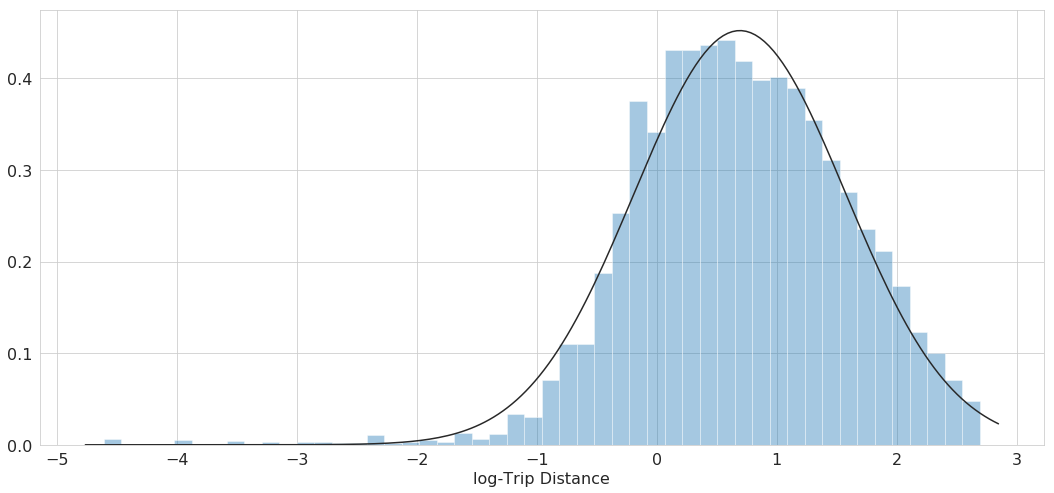

In [13]:
# Calculating the log-trip distances
log_trip_distance = np.log(y)
# Fitting a normal distribution
sns.distplot(log_trip_distance, kde=False, fit=stats.norm);
plt.xlabel('log-Trip Distance')

The log-trip distance shows a normal distribution which supports the hypothesis that the trip distance distribution is log-normal in nature. From the discussion [here](https://en.wikipedia.org/wiki/Log-normal_distribution), it can be hypothesised that the trip distance distribution arises due to the multiplication of several normally distributed positive random variables. Some of these factors can include - 

* The customer profile
* Weather
* Time of the day
* Locality of the cab services

In [14]:
df.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,0.00,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,0.00,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,0.59,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,0.74,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,0.61,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0


We can extract the time of day from the `'lpep_pickup_datetime'` field in the dataset, by converting it to a `datetime` object

In [0]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
# Use the dt.hour method to get the time of day
df['Hour'] = df['lpep_pickup_datetime'].dt.hour

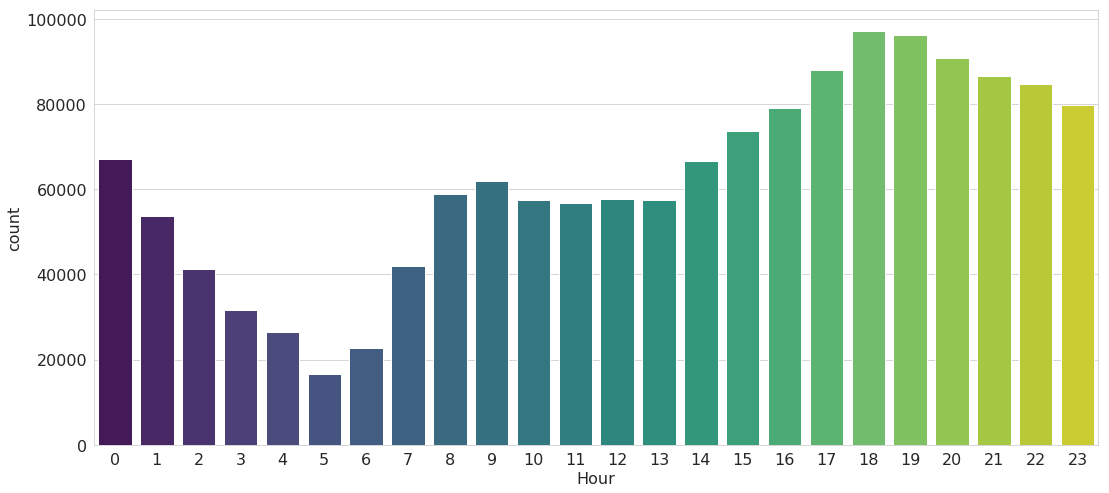

In [16]:
# Visualize the distribution of the number of trips w.r.t the time of day
sns.countplot(x='Hour',data=df,palette='viridis')

As can be expected, the number of trips reach their maximal levels during the evening rush hours between 5 to 9 p.m., and can be reasonably assumed to be due to the close of business, as well as increased travel for leisure, chores etc. The number of trips remain somewhat constant during the day, and dip sharply during the night-time hours between 2 to 6 a.m., when there is not much activity.

Further looking into the trip distance grouped by the hour of day,

In [0]:
td_hour_mean = df.groupby('Hour')['Trip_distance'].mean()
td_hour_median = df.groupby('Hour')['Trip_distance'].median()

In [18]:
td_hour_mean

Hour
0     3.115276
1     3.017347
2     3.046176
3     3.212945
4     3.526555
5     4.133474
6     4.055149
7     3.284394
8     3.048450
9     2.999105
10    2.944482
11    2.912015
12    2.903065
13    2.878294
14    2.864304
15    2.857040
16    2.779852
17    2.679114
18    2.653222
19    2.715597
20    2.777052
21    2.999189
22    3.185394
23    3.191538
Name: Trip_distance, dtype: float64

In [19]:
td_hour_median

Hour
0     2.20
1     2.12
2     2.14
3     2.20
4     2.36
5     2.90
6     2.84
7     2.17
8     1.98
9     1.96
10    1.92
11    1.88
12    1.89
13    1.84
14    1.83
15    1.81
16    1.80
17    1.78
18    1.80
19    1.85
20    1.90
21    2.03
22    2.20
23    2.22
Name: Trip_distance, dtype: float64

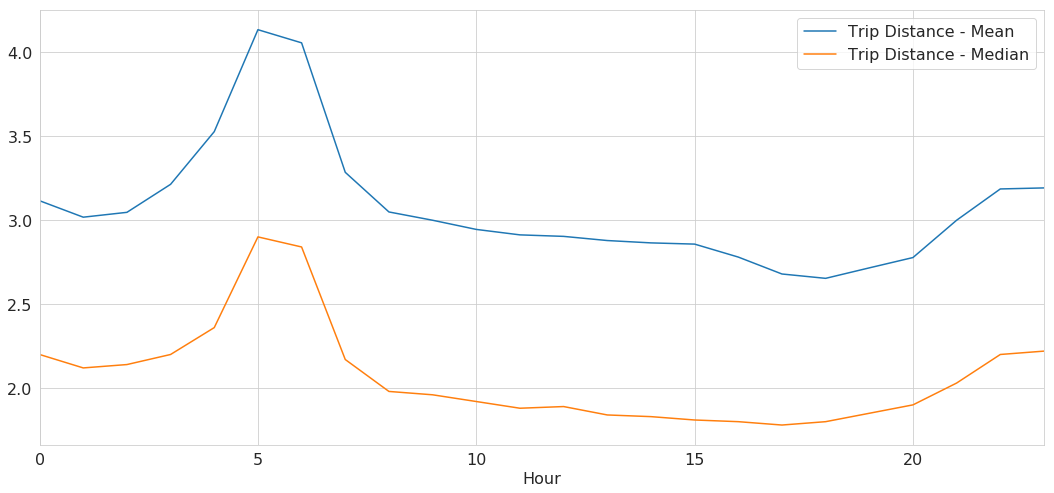

In [20]:
td_hour_mean.plot(label='Trip Distance - Mean')
td_hour_median.plot(label='Trip Distance - Median')
plt.legend()

The mean trip distance grouped by hour provides intuition into the types of trips that are taken at different times of the day. During the early hours of morning most trips tend to be long distance, for e.g. trips across NYC. The trips undertaken later in the day would most likely fall into urban-region trips covering small distances between shops or other commercial establishments. 

### Airport Trips <a name="airport"></a>
NYC has 3 major airports, as mentioned [here](https://www.ny.com/transportation/airports/)-

* JFK - John F. Kennedy Airport
* LGA - LaGuardia Airport
* EWR - Newark International Airport

For identifying trips that originate or terminate at one of the airports, we need to use the pickup and dropoff latitude and longitude data. By taking the trips that lie within some particular radius of the airport latitudes and longitudes, we can identify the relevant airport trips.

As a first approach, we try the geopy package (available [here](https://pypi.python.org/pypi/geopy)) to calculate the distance from the airport. A 0.5-mile radius window around the airport latitudes and longitudes should be sufficient to account for all the possible airport trip lats and longitudes that can occur.


```
# Obtain the airport latitudes and longitudes from Google Maps
jfk_airport = (40.646020, -73.775833)
lga_airport = (40.776943, -73.873955)
ewr_airport = (40.689617, -74.174430)

from geopy.distance import vincenty

# Define a function that checks whether the trip originates or terminates within 0.5 miles radius of 
# any of the airports

def airport_check(rec):
    pickup_loc = (rec['Pickup_latitude'],rec['Pickup_longitude'])
    dropoff_loc = (rec['Dropoff_latitude'],rec['Dropoff_longitude'])
    
    # The vincenty function calculates the geodesic distance between two points, here between the trip 
    # origin or end, and the airport lat,long
    jfk_trip = ((vincenty(jfk_airport, pickup_loc).miles<=0.5) | \
    (vincenty(jfk_airport, dropoff_loc).miles<=0.5))
    lga_trip = ((vincenty(lga_airport, pickup_loc).miles<=0.5) | \
    (vincenty(lga_airport, dropoff_loc).miles<=0.5))
    ewr_trip = ((vincenty(ewr_airport, pickup_loc).miles<=0.5) | \
    (vincenty(ewr_airport, dropoff_loc).miles<=0.5))

    # Check if any airport condition is satisfied
    airport_trip = (jfk_trip | lga_trip | ewr_trip)
    return (airport_trip)

# Apply to each record of the data
df['Airport'] = df[df.apply(lambda rec: airport_check(rec)==True, axis=1)]
```

The problem with using this approach was the looping over all the records, which resulted in excessively long times to determine the data. We instead adopt a vectorized approach, using a fast haversine distance approximator function, as discussed [here](http://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas).

In [0]:
jfk_airport = (40.646020, -73.775833)
lga_airport = (40.776943, -73.873955)
ewr_airport = (40.689617, -74.174430)

# using the fast haversine geodesic distance approximation
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    miles = 0.62 * km
    return miles

# Specify the radius within which to search for trip origin or end points
radius = 0.5

# Create vectors of the airport latitudes and longitudes
jfk_lon = np.repeat(jfk_airport[1], len(df))
jfk_lat = np.repeat(jfk_airport[0], len(df))

lga_lon = np.repeat(lga_airport[1], len(df))
lga_lat = np.repeat(lga_airport[0], len(df))

ewr_lon = np.repeat(lga_airport[1], len(df))
ewr_lat = np.repeat(lga_airport[0], len(df))

# Create boolean condition variables with value=True if the trip originates or terminates within a distance
# 'radius' from the airports location
df['jfk_trip'] = (haversine_np(jfk_lon, jfk_lat, df['Pickup_longitude'], df['Pickup_latitude']) \
                  <= radius) | \
(haversine_np(jfk_lon, jfk_lat, df['Dropoff_longitude'], df['Dropoff_latitude']) <= radius)

df['lga_trip'] = (haversine_np(lga_lon, lga_lat, df['Pickup_longitude'], df['Pickup_latitude']) \
                  <= radius) | \
(haversine_np(lga_lon, lga_lat, df['Dropoff_longitude'], df['Dropoff_latitude']) <= radius)

df['ewr_trip'] = (haversine_np(ewr_lon, ewr_lat, df['Pickup_longitude'], df['Pickup_latitude']) \
                  <= radius) | \
(haversine_np(ewr_lon, ewr_lat, df['Dropoff_longitude'], df['Dropoff_latitude']) <= radius)

# Create a new dataframe with records that contain only airport trips
df_airport = df[df['jfk_trip'] | df['lga_trip'] | df['ewr_trip']]

In [22]:
# Check the info of the airport trips dataframe
df_airport.info()
df_airport.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20385 entries, 26 to 1494573
Data columns (total 25 columns):
VendorID                 20385 non-null int64
lpep_pickup_datetime     20385 non-null datetime64[ns]
Lpep_dropoff_datetime    20385 non-null object
Store_and_fwd_flag       20385 non-null object
RateCodeID               20385 non-null int64
Pickup_longitude         20385 non-null float64
Pickup_latitude          20385 non-null float64
Dropoff_longitude        20385 non-null float64
Dropoff_latitude         20385 non-null float64
Passenger_count          20385 non-null int64
Trip_distance            20385 non-null float64
Fare_amount              20385 non-null float64
Extra                    20385 non-null float64
MTA_tax                  20385 non-null float64
Tip_amount               20385 non-null float64
Tolls_amount             20385 non-null float64
Ehail_fee                0 non-null float64
improvement_surcharge    20385 non-null float64
Total_amount             2038

In [23]:
len(df_airport)

20385

Approximately 20385 transactions fit into the criteria of being airport trips. Of course, the accuracy of this number depends on the radius we set in the previous step, as too small or too large of a radius can result in incorrect number of trips. The average fare amount can be checked as well-

In [24]:
df_airport['Fare_amount'].mean()

28.877678685307824

In [25]:
df['Fare_amount'].mean()

12.543197516131235

As expected the average fare for the airport trips is more than twice the average fare of all the transactions considered. This makes sense since airport trips generally tend to be longer with regards to distance and time, and generally end up having higher fares. Another interesting feature that we observe is that many trips originate from one of the airports and end at a different airport.

In [26]:
# Define a function to check whether a trip satisfies multiple airport conditions
def multiple_airport(rec):
    return ([rec['jfk_trip'], rec['lga_trip'], rec['ewr_trip']].count(True)>1)

len(df_airport[df_airport.apply(lambda rec: multiple_airport(rec)==True, axis=1)])

12138

Out of `20385`, `12138` (more than `50%`) are trips that are both pick-ups and drop-offs at airports. This is interesting and may be due to a high number of passengers taking connecting flights between the different airports in New York. We make some more visualizations in order to explore the data. Most of the airport trips are observed to occur during the daytime hours.

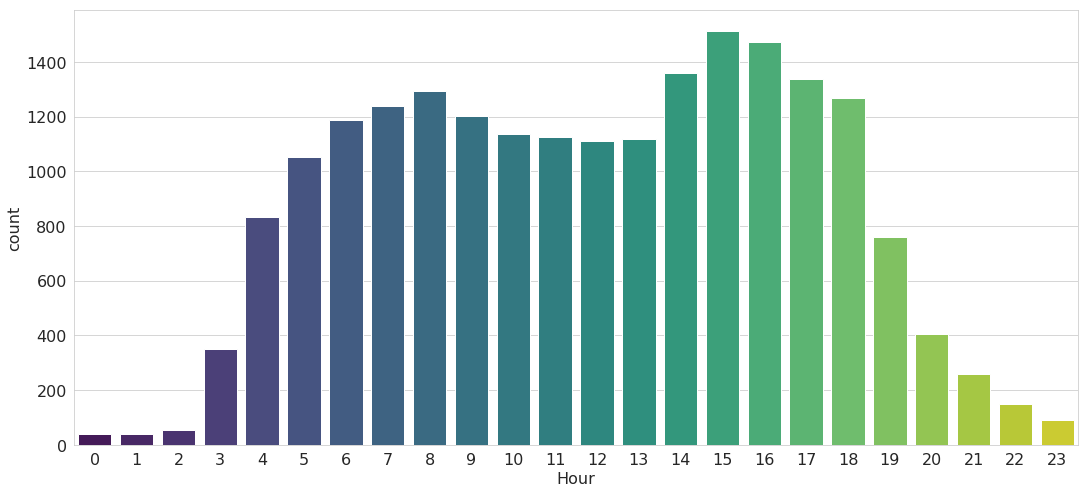

In [27]:
# Visualize the distribution of the number of airport trips w.r.t the time of day
sns.countplot(x='Hour',data=df_airport,palette='viridis')

Another interesting characteristic of the airport trips is that in a majority of the trips, payment was made via credit card, which are of `'Payment_type'=1`. This can give some indication about the customer profile of the passengers who make airport trips.

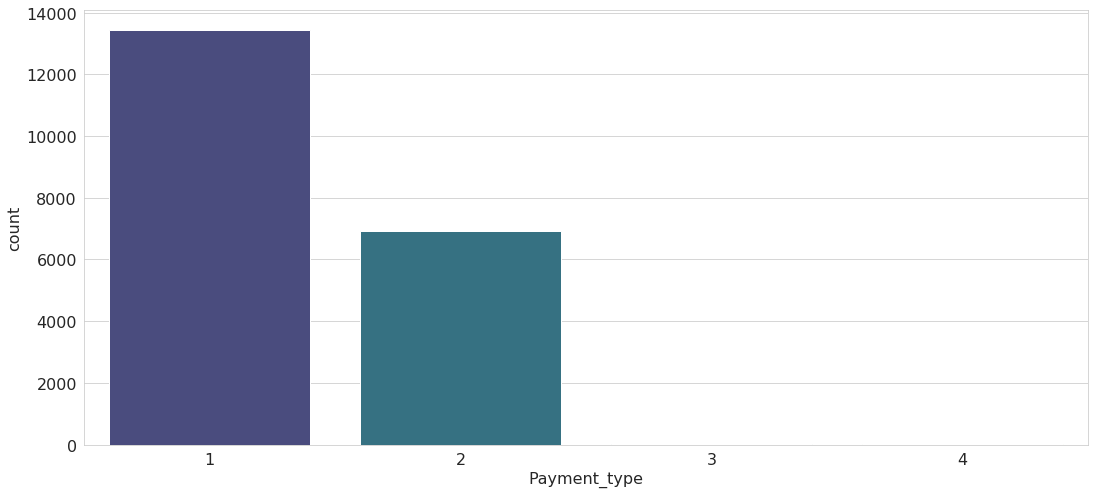

In [28]:
sns.countplot(x='Payment_type',data=df_airport,palette='viridis')

## Predictive Model for Tip <a name="predictive"></a>

### Feature Engineering <a name="featureengg"></a>

We build a derived variable for tip as a percentage of the total fare. Returning back to the original dataframe, we see that in several of the records, the total fare amount is 0.0, which would give an invalid value for the tip percentage, if calculated directly. In order to rectify this, we replace zero-valued total amounts with the median value. In addition the total amounts and tips are negative for the records with `Payment_type = Not charged`. These records are of customer refunds, and since both the values are negative, the tip percentage remains valid. Checking the distribution of the total amount,

In [29]:
df['Total_amount'].describe()

count    1.494926e+06
mean     1.503215e+01
std      1.155316e+01
min     -4.750000e+02
25%      8.160000e+00
50%      1.176000e+01
75%      1.830000e+01
max      5.813000e+02
Name: Total_amount, dtype: float64

In [0]:
total_amount_median = df['Total_amount'].median()
df['Total_amount'] = df['Total_amount'].apply(lambda rec: rec if rec!=0.0 else \
                                              total_amount_median)

In [0]:
# Now calculate the tip_perc derived variable as a percentage of the total amounts
df['Tip_perc'] = (df['Tip_amount']/df['Total_amount'])*100

In [32]:
df['Tip_perc'].describe()

count    1.494926e+06
mean     6.635257e+00
std      8.869714e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e+01
max      1.000000e+02
Name: Tip_perc, dtype: float64

In [33]:
# Checking the 99th percentile
np.percentile(df['Tip_perc'], 99)

23.07692307692308

Text(0.5,0,'Tip %')

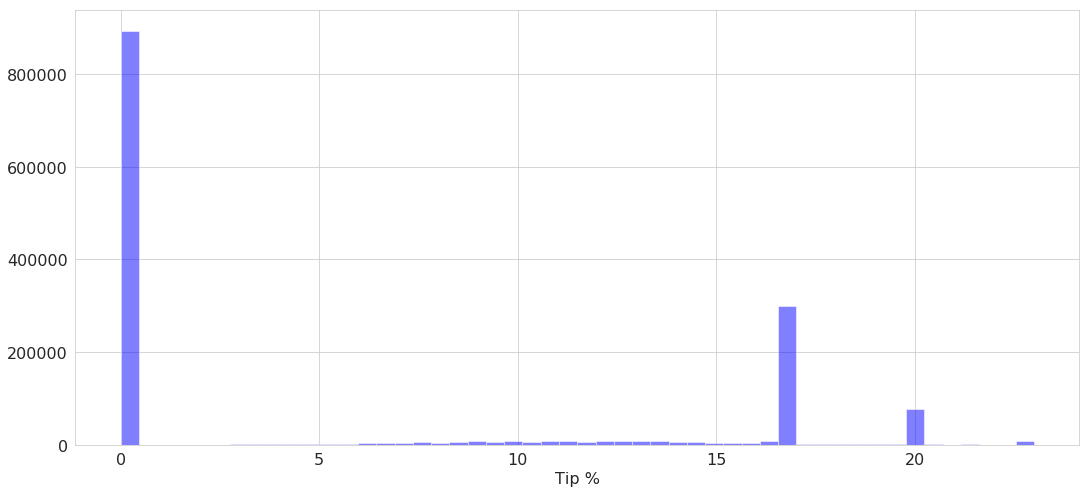

In [34]:
df[df['Tip_perc']<23]['Tip_perc'].hist(alpha=0.5,color='blue',bins=50)
plt.xlabel('Tip %')

The histogram of the tip percentages shows a majority lie at 0%. This is due to the fact that cash tips are not reported and are not included in the total amount, as described in the data dictionary. On the other hand, credit card tip percentages are automatically generated, which causes the peak at ~16% observed in the histogram. Some of the passengers may change the automatically generated tip percentages, which gives rise to the smaller number of different tip percentage values. Before selecting a model we perform some more feature engineering, and use the trip distance data and trip time data to create a trip speed variable, which may affect the tip percentage. 

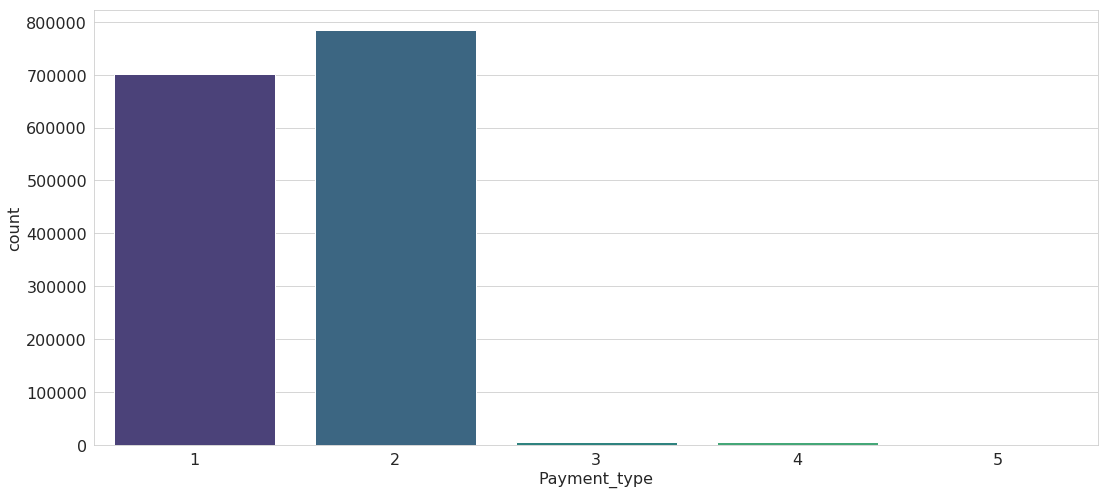

In [35]:
sns.countplot(x='Payment_type',data=df,palette='viridis')

As is observed in the above figure, the payment types are mainly credit card or cash, with cash tips not being included in the records. The other payment types of type `No charge` or `Unknown` are very few in number, and we dont consider them while building our model.

For calculating the time taken for each trip, we use the pickup time and dropoff time, and find the difference between the two as a timedelta object. This object can then be converted to seconds using the `astype` method, and then can be further converted to the trip time in hours.

In [0]:
# Convert to datetime object
df['Lpep_dropoff_datetime'] = pd.to_datetime(df['Lpep_dropoff_datetime'])
time_diff = df['Lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['Trip_time'] = (time_diff.astype('timedelta64[s]')/3600.0)

In [37]:
df['Trip_time'].describe()

count    1.494926e+06
mean     3.377105e-01
std      1.615088e+00
min      0.000000e+00
25%      1.030556e-01
50%      1.738889e-01
75%      2.877778e-01
max      2.399833e+01
Name: Trip_time, dtype: float64

Again, the zero-valued trip times have to be replaced by the median value in order to prevent incorrect measurements for trip speed.

In [0]:
median_time = df['Trip_time'].median()
df['Trip_time'] = df['Trip_time'].apply(lambda rec: rec if rec>0.0 else median_time)

df['Trip_speed'] = df['Trip_distance']/(df['Trip_time'])

In [39]:
df['Trip_speed'].describe()

count    1.494926e+06
mean     1.578368e+01
std      2.158176e+02
min      0.000000e+00
25%      9.308707e+00
50%      1.176471e+01
75%      1.506273e+01
max      2.026800e+05
Name: Trip_speed, dtype: float64

The anomalous values in trip speed are replaced before proceeding with model building.

In [0]:
median_speed = df['Trip_speed'].median()
# Replace trip speeds above 150 miles/hr with median values
df['Trip_speed'] = df['Trip_speed'].apply(lambda rec: rec if rec<150.0 else median_speed)

In [41]:
df['Trip_speed'].describe()

count    1.494926e+06
mean     1.285208e+01
std      6.294127e+00
min      0.000000e+00
25%      9.308707e+00
50%      1.176471e+01
75%      1.502856e+01
max      1.494340e+02
Name: Trip_speed, dtype: float64

Text(0.5,0,'Trip Speed')

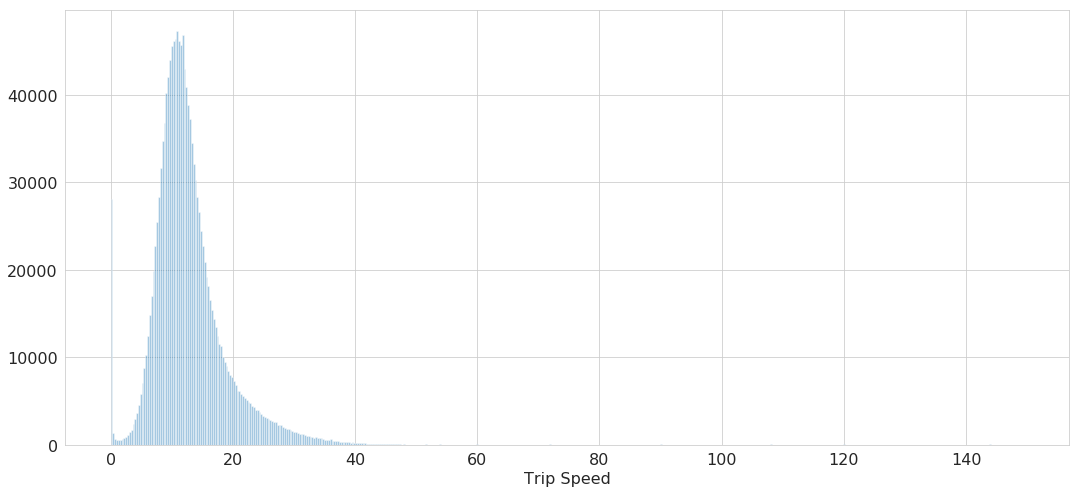

In [42]:
sns.distplot(df['Trip_speed'], kde=False, rug=False, bins=500);
plt.xlabel('Trip Speed')

The 'Trip_speed' column gives the average speed over the course of a trip, in miles/hour. The time for each trip was calculated in hours, and according to the data dictionary, the trip distance is in miles. Additionally we also cleaned and replaced illogical trip speed values with more suitable replacement values.

In [43]:
df['Trip_speed'].describe()

count    1.494926e+06
mean     1.285208e+01
std      6.294127e+00
min      0.000000e+00
25%      9.308707e+00
50%      1.176471e+01
75%      1.502856e+01
max      1.494340e+02
Name: Trip_speed, dtype: float64

For obtaining the week number of a particular trip, we use the information [here](http://pandas.pydata.org/pandas-docs/stable/api.html#datetimelike-properties). The week ordinal of the year gives the week number out of all the total weeks in the year, and this number can be used to group the trips.


In [0]:
df['Week_num'] = df['lpep_pickup_datetime'].dt.week

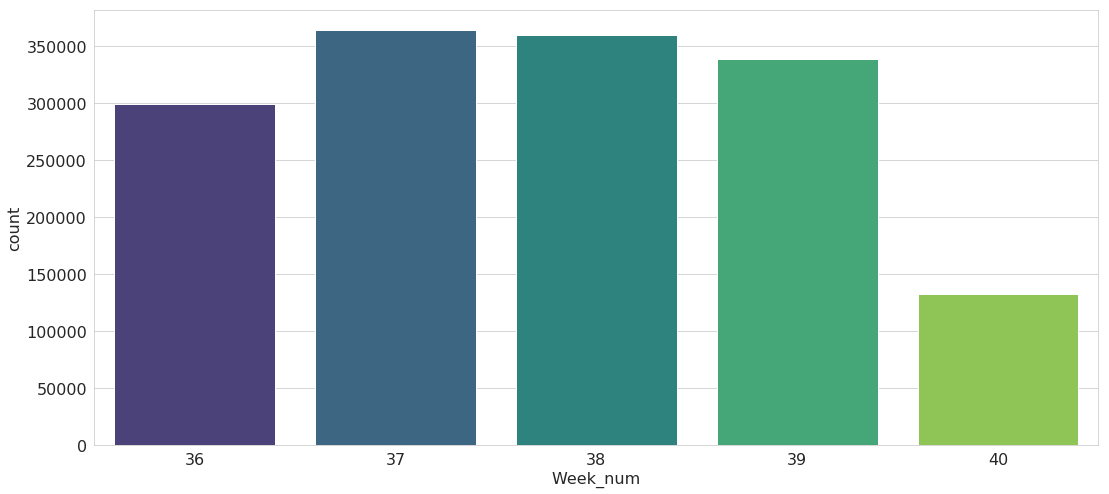

In [45]:
sns.countplot(x='Week_num',data=df,palette='viridis')

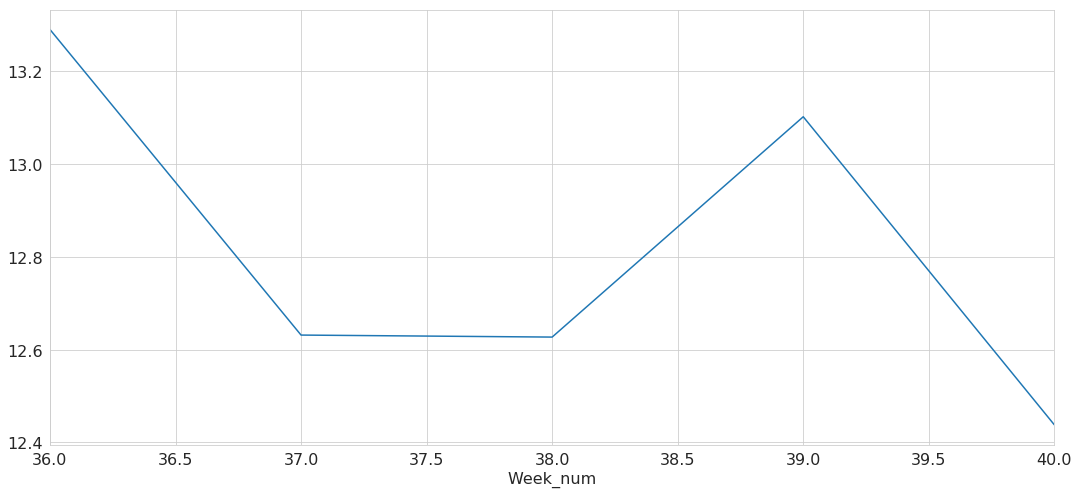

In [46]:
df.groupby('Week_num')['Trip_speed'].mean().plot()

This analysis shows that the average trip speeds are approximately the same during all the weeks of September. The discrepancy in the number of trips in the first and last week is due to there being only 5 days and 4 days in the first and last weeks respectively




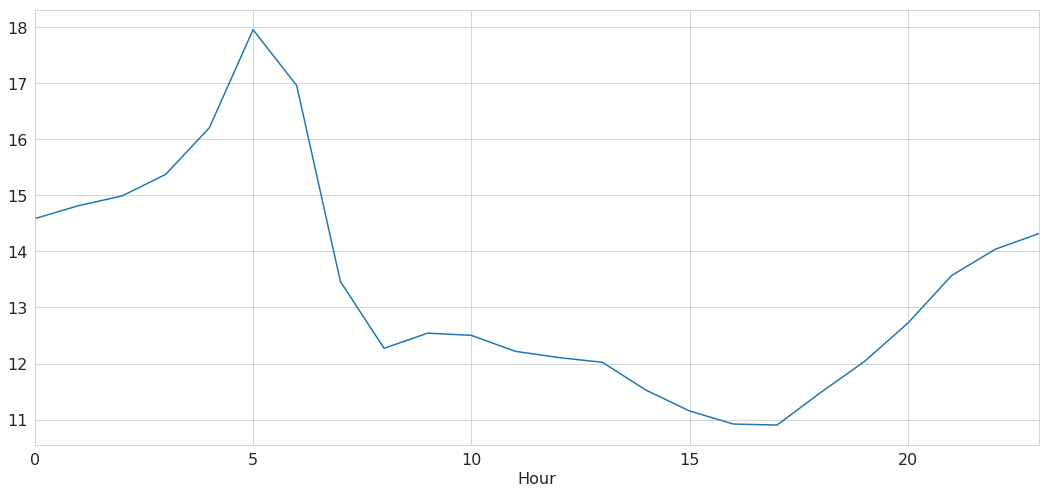

In [47]:
df.groupby('Hour')['Trip_speed'].mean().plot()

The variation in speed with the time of day is due to the traffic, peak time hours etc. During the night-time there would not be much traffic on the roads, and the average speed would be high as shown in the graph. Noticeable dips are observed during the morning and evening office rush hours, which correspond to high volumes of cars plying on the roads.

An additional feature that may affect the tipping percentage is the day of the week. Before proceeding further, we can also drop the `Ehail fee` column and impute NaN values for `Trip type` column.

In [0]:
df['Day'] = df['lpep_pickup_datetime'].dt.dayofweek
credit_card = (df['Payment_type']==1)

In [0]:
df.drop('Ehail_fee', axis=1, inplace=True)

In [0]:
df.fillna(method='pad',inplace=True)

### Building and Evaluating the Model <a name="buildingmodel"></a>

In the scenario in which to build a predictive model for the tip as a percentage of the total fare, it would be reasonable to assume that we would have no information about the `tip amount`, the `tolls amount` or the `fare amount`, since if we have information on any of these, it would be trivially easy to calculate the remaining variable, since $$Total\ Amount = Tip\ Amount + Fare\ Amount + Miscellaneous\ charges$$

Due to this reason, we take only the total amount in the training data. Other features of interest include the number of passengers, the trip distance, time and speed, the payment type, the time of day and day of the week. The target variable is the tip percentage. We create a new dataframe containing these records.

In [0]:
# Create a new dataframe consisting of relevant features from the taxi trips dataset
df_tips = df[['Passenger_count','Trip_distance','Trip_time','Trip_speed', \
                    'Total_amount','Payment_type','Day',\
                    'Hour','Tip_perc']].copy()

In [52]:
df_tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494926 entries, 0 to 1494925
Data columns (total 9 columns):
Passenger_count    1494926 non-null int64
Trip_distance      1494926 non-null float64
Trip_time          1494926 non-null float64
Trip_speed         1494926 non-null float64
Total_amount       1494926 non-null float64
Payment_type       1494926 non-null int64
Day                1494926 non-null int64
Hour               1494926 non-null int64
Tip_perc           1494926 non-null float64
dtypes: float64(5), int64(4)
memory usage: 102.6 MB


From the features that we have seen so far, there appears to be a highly non-linear relationship between the feature vectors and the target tip percentage. A good model that can deal with these non-linearities is the random forest regressor. The RF model can give us the flexibility required in order to decide appropriate decision boundaries given the data. Some of the main parameters considered include- 

* n_estimators - the number of trees in the forest. The test error does not generally increase as we increase the number of trees, and we take a number such that the error stabilises
* max_features - this is the number of features considered at each split, and is generally recommended to be $\sqrt{p}$ , where  pp  is the total number of features. This is given by the `'sqrt'` option. The `'auto'` option sets the max_features to the total number of features.

In [0]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X = df_tips.drop('Tip_perc',axis=1)
y = df_tips['Tip_perc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [54]:
from sklearn.ensemble import RandomForestRegressor

rf_estimator = RandomForestRegressor(n_estimators=50, max_features='sqrt')
rf_estimator.fit(X_train,y_train)
rf_estimator.score(X_test,y_test)

0.8872092037147655

The score method of the estimator returns the $R^2$ coefficient of determination of the prediction, which is seen to be ~0.9. Using 3-fold cross validation, instead of the train-test-split gives approximately the same score. This implies that the model explains about 90% of the variability of the data. This is quite good, given that the number of trees used is not very high. 

Now we check the relative importance of each of the features we have used while building the model. For this we can use the `feature_importances_` attribute of our trained tree. This attribute gives the relative importance of each feature that decides the tip percentage. The sum of the individual feature importances also sums to 1.

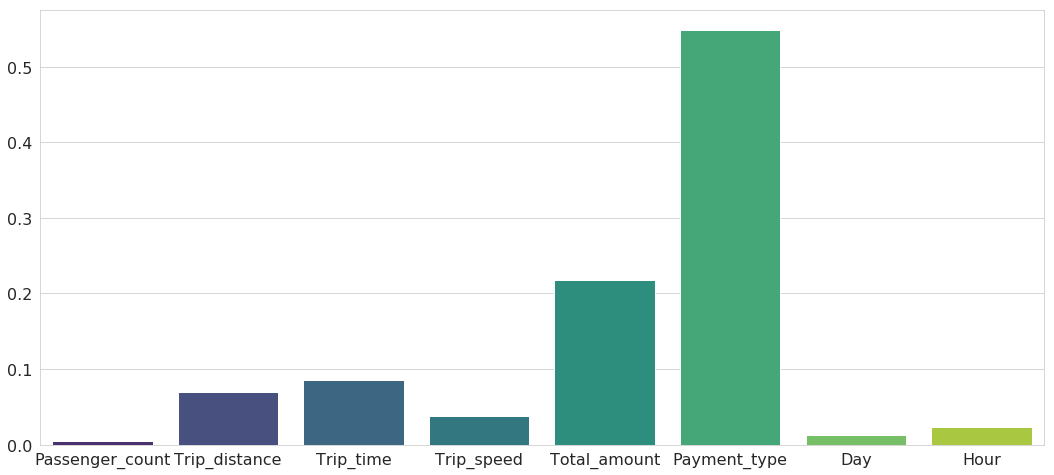

In [55]:
# Plot the features and their corresponding importances
features = X.columns.tolist()
feature_importances = rf_estimator.feature_importances_
sns.barplot(x=features, y=feature_importances, palette='viridis')

The plot is in line with our earlier inference that the payment type would be a very important factor while making splits, due to the fact that cash tips are not reported in the taxi records. Following this the total amount is an important factor which determines the tip percentage. In line with our inferences again, the trip distance, times taken and speed also influence the final tip percentage.

A possible way to improve this score by performing a randomized grid search over some of the important parameters of the random forest regressor, as per the discussion [here](http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html). This is done for hyperparameter optimization. The additional parameters we check include-

* min_samples_split - this is the minimum number of samples to split an internal node
* min_samples_leaf - this is basically the minimum number of samples required to be a leaf node, i.e. a node containing samples from a single decision region
* bootstrap - bootstrapping is a way of selecting samples from the input

```
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

rf_estimator_2 = RandomForestRegressor(n_estimators=500)
param_dist = {"max_features": ['auto','sqrt'],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(2, 11),
              "bootstrap": [True, False]}
rndm_RF = RandomizedSearchCV(rf_estimator_2, param_distributions=param_dist,
                                   n_iter=10)
rndm_RF.fit(X, y)
rndm_RF.cv_results_
```
